# Topic modeling

### Load data

In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
CLEAN_SUBTITLES = '/home/angelo/Desktop/master_offline/progettone/subtitles/clean_subtitles/Disney/Animation'

subtitles = np.ndarray(shape=(0,3))

for r,d,files in os.walk(CLEAN_SUBTITLES):
    for f in files:
        with open(os.path.join(r,f), 'r', encoding='utf-8', errors='ignore') as r_fh:
            f_tokens = f.split('.')
            subtitles = np.append(subtitles, [[f_tokens[0], r[-4:], r_fh.read()]], axis=0)
            
documents = subtitles[:,2]

### Utils

In [3]:
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english') + ['shh', 'hoo', 'boo', 'uhoh', 'aah', 'heh', 'huh', 'ooh']

import spacy
nlp = spacy.load('en')

# split too long document (char_len > 1'000'000'000)
def lemmatization_single_doc(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text_split = []
    if len(text) > 1000000:
        split_pos = text.find('.', 900000)
        text_split.append(text[:split_pos+1])
        text_split.append(text[split_pos+1:])
    else:
        text_split.append(text)
        
    text_out = []
    for t in text_split:
        doc = nlp(t) 
        partial_tokens = [
            token.text if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags
        ]
        text_out = text_out + partial_tokens 
        
    return " ".join(text_out)  


def lemmatization(texts):
    texts_out = []
    for text in texts: 
        texts_out.append(lemmatization_single_doc(text, ['NOUN']))
    return texts_out


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f'Topic {topic_idx}: '
        message += ', '.join(
            [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        )
        print(message,'\n')
    print()
    return

### Lemmatization and Tokenization

In [4]:
lem_documents = lemmatization(documents.tolist())

### Features extraction

In [5]:
tf_vectorizer = CountVectorizer(
    stop_words=en_stopwords,
    max_df=0.50,
    min_df=5,
    #ngram_range=(1,2),
    token_pattern='[a-zA-Z0-9]{3,}',
    lowercase=True
)

tf = tf_vectorizer.fit_transform(lem_documents)

### LDA

In [6]:
n_components = 20

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=10000,
    learning_method = 'batch',
    n_jobs=-1,
    verbose=0
)

lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10000,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [7]:
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic 0: lamp, tree, wish, tail, master, treasure, bounce, party, pot, pit, letter, bear, sort, jump, diamond, others, note, ball, prize, sight 

Topic 1: game, team, party, dad, song, line, program, treasure, bird, stories, music, games, cake, road, prince, spring, dust, candy, building, monsters 

Topic 2: music, daddy, hair, princess, prince, frog, photo, song, child, gift, songs, kingdom, birthday, daughter, restaurant, tower, dreams, dress, shoes, future 

Topic 3: toy, toys, cowboy, box, kids, hat, voice, store, infinity, space, sky, trash, birthday, college, buddy, pal, right, mom, back, lives 

Topic 4: race, road, tires, speed, racing, ride, racer, lightning, town, track, miles, folks, lap, land, diamond, rookie, number, storm, season, hour 

Topic 5: pig, farm, rain, conscience, girls, money, strings, sword, toad, horse, case, hat, land, school, road, cow, town, grace, hour, range 

Topic 6: king, food, jungle, bugs, bird, kingdom, village, sword, lad, rules, bear, fish, prin

### Projecting documents into topics

In [8]:
topics = lda.transform(tf)

tdf = pd.DataFrame(topics)
tdf.insert(loc=0, column='decade', value=subtitles[:,1])
tdf.insert(loc=0, column='movie', value=subtitles[:,0])
print('shape:', tdf.shape)
tdf.head(10)

shape: (88, 22)


,movie,decade,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,Hercules,1990,0.000097,0.029087,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,...,0.000097,0.169137,0.000097,0.000097,0.000097,0.000097,0.162159,0.086611,0.000097,0.551550
1,Toy Story,1990,0.000092,0.000092,0.000092,0.998254,0.000092,0.000092,0.000092,0.000092,...,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092
2,A Goofy Movie,1990,0.000134,0.557738,0.000134,0.000134,0.000134,0.093263,0.000134,0.000134,...,0.066045,0.000134,0.000134,0.000134,0.000134,0.000134,0.268091,0.000134,0.000134,0.000134
3,A Bug's Life,1990,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.998297,0.000090,...,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090
4,The Nightmare Before Christmas,1990,0.000133,0.000133,0.113150,0.161900,0.000133,0.000133,0.223992,0.127000,...,0.000133,0.000133,0.000133,0.040198,0.000133,0.085235,0.000133,0.000133,0.000133,0.152994
5,The Lion King,1990,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.508653,0.000123,...,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.489130,0.000123,0.000123
6,The Rescuers Down Under,1990,0.000164,0.000164,0.000164,0.000164,0.000164,0.000164,0.000164,0.000164,...,0.000164,0.000164,0.000164,0.000164,0.000164,0.000164,0.000164,0.000164,0.000164,0.996875
7,Aladdin,1990,0.239634,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,...,0.008947,0.749778,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097
8,Pocahontas,1990,0.013219,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,...,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.984879,0.000106
9,Beauty and the Beast,1990,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,...,0.000113,0.000113,0.997860,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113


#### Dataframe to json graph (for visualization)

In [9]:
movie_decade_map = {}
for pair in tdf.values[:,0:2]:
    movie_decade_map[pair[0]] = pair[1]

In [10]:
topic_nodes = set([str(c) for c in tdf.columns if c not in ['movie', 'decade']])
movie_nodes = set(tdf['movie'])

graph_list = []
for i in tdf.values:
    for t, j in enumerate(range(2, len(i))):
            graph_list.append((i[0], t, i[j]))
            
graph = dict()
graph["nodes"] = [{"id": tn, "group": 'topic', "decade": "none"} for tn in topic_nodes]
graph["nodes"] = graph["nodes"] + [{"id": mn, "group": 'movie', "decade": movie_decade_map[mn]} for mn in movie_nodes]
graph["links"] = [{"source":t[0], "target":str(t[1]), "value":float(t[2])} for t in graph_list]

with open('data.json', 'w') as outfile:
    json.dump(graph, outfile)

### Group by 'decade' then aggregate by 'mean'

In [11]:
mean_df = tdf.loc[:, tdf.columns != 'movie'].groupby(by=['decade']).agg('mean')
mean_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
decade,,,,,,,,,,,,,,,,,,,,
1930,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.996619,0.000178,0.000178,0.000178,0.000178
1940,0.000193,0.248569,0.000193,0.000193,0.017170,0.343695,0.043884,0.055219,0.008983,0.000193,0.000193,0.000193,0.021540,0.188278,0.026443,0.015281,0.000193,0.000193,0.000193,0.029204
1950,0.000142,0.000142,0.126159,0.000142,0.000142,0.000142,0.029796,0.159860,0.199660,0.021812,0.029401,0.000142,0.236073,0.000142,0.037046,0.000142,0.000142,0.000142,0.023793,0.134983
1960,0.000123,0.000123,0.031217,0.000123,0.021963,0.000123,0.302482,0.086564,0.027361,0.010798,0.019752,0.000123,0.024385,0.000123,0.000123,0.000123,0.024129,0.000123,0.000123,0.450118
1970,0.044617,0.000143,0.000143,0.000143,0.212989,0.083146,0.031082,0.019453,0.000143,0.086699,0.006602,0.013119,0.306116,0.000143,0.000143,0.000143,0.000143,0.000143,0.000143,0.194750
1980,0.000171,0.000171,0.049469,0.000171,0.000171,0.199465,0.000171,0.000171,0.000171,0.000171,0.199635,0.000171,0.000171,0.000171,0.000171,0.033637,0.000171,0.072217,0.199500,0.243850
1990,0.070447,0.039227,0.043164,0.125641,0.000121,0.018794,0.115494,0.012424,0.007222,0.001830,0.005105,0.135802,0.066637,0.007368,0.002247,0.073191,0.036998,0.038489,0.065772,0.134029
2000,0.021534,0.038437,0.037155,0.053517,0.045204,0.040175,0.058453,0.105393,0.129446,0.083086,0.094243,0.046670,0.008980,0.000125,0.114615,0.014246,0.023196,0.074098,0.004011,0.007418
2010,0.041195,0.041174,0.068416,0.074539,0.070575,0.006581,0.056225,0.052116,0.029980,0.002089,0.054173,0.039088,0.034350,0.036276,0.000115,0.041573,0.153466,0.116162,0.072690,0.009217


## ALL MOVIES OF A DECADE IN ONLY ONE DOCUMENT

### Load data

In [12]:
decade_subs = np.ndarray(shape=(0,2))

for r,d,files in os.walk(CLEAN_SUBTITLES):
    if (len(files) < 1):
        continue
        
    subs = str()
    for f in files:
        with open(os.path.join(r,f), 'r', encoding='utf-8', errors='ignore') as r_fh:
            subs = subs + ' ' + r_fh.read()
            
    decade_subs = np.append(decade_subs, [[r[-4:], subs]], axis=0)
            
decade_documents = decade_subs[:,1]

### Lemmatization and Tokenization

In [13]:
decade_lem_documents = lemmatization(decade_documents.tolist())

### Features extraction

In [14]:
decade_tf = tf_vectorizer.transform(decade_lem_documents)

### LDA - Projecting decade documents into topics

In [15]:
decade_topics = lda.transform(decade_tf)

### Decades - Topics dataframe

In [16]:
decade_tdf = pd.DataFrame(decade_topics)
decade_tdf.insert(loc=0, column='decade', value=decade_subs[:,0])
print('shape:', tdf.shape)
decade_tdf.set_index('decade',inplace=True)
decade_tdf.sort_index(inplace=True)
decade_tdf.head(10)

shape: (88, 22)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
decade,,,,,,,,,,,,,,,,,,,,
1930,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.996619,0.000178,0.000178,0.000178,0.000178
1940,0.000043,0.108367,0.012069,0.000043,0.021999,0.406700,0.055154,0.070839,0.000043,0.000043,0.000043,0.000043,0.030487,0.186748,0.043195,0.000043,0.010488,0.000043,0.012778,0.040834
1950,0.000027,0.000027,0.132480,0.004435,0.000027,0.000027,0.030705,0.186456,0.203933,0.014855,0.000027,0.000027,0.243034,0.000027,0.031404,0.000027,0.000027,0.007579,0.043051,0.101820
1960,0.000040,0.000040,0.032888,0.000040,0.018948,0.010290,0.438032,0.086437,0.026474,0.017011,0.016954,0.000040,0.015055,0.000040,0.000040,0.000040,0.010405,0.000040,0.000040,0.327142
1970,0.069386,0.000035,0.000035,0.004069,0.126743,0.103151,0.030368,0.034481,0.009327,0.112375,0.000035,0.012149,0.239299,0.006461,0.000035,0.000035,0.000035,0.000035,0.000035,0.251915
1980,0.000032,0.000032,0.078077,0.000032,0.000032,0.184397,0.000032,0.000032,0.002737,0.000032,0.178750,0.000032,0.070018,0.000032,0.000032,0.072400,0.000032,0.083624,0.158951,0.170696
1990,0.064023,0.027434,0.032531,0.173607,0.002616,0.023078,0.157727,0.030596,0.028720,0.000008,0.000008,0.090771,0.049695,0.003299,0.002358,0.056101,0.034426,0.026659,0.069884,0.126459
2000,0.006140,0.010703,0.044508,0.046501,0.056560,0.030709,0.050306,0.137267,0.149754,0.062558,0.105999,0.036057,0.009074,0.000004,0.077143,0.008928,0.054510,0.073809,0.000806,0.038665
2010,0.014445,0.045031,0.052851,0.093166,0.109625,0.004645,0.029239,0.072632,0.000004,0.000004,0.039709,0.067265,0.048596,0.016759,0.000004,0.046001,0.185984,0.120290,0.051976,0.001774


## RESULT BY DECADE
#### Two aggregation methods: by "all in one decade document" and by mean

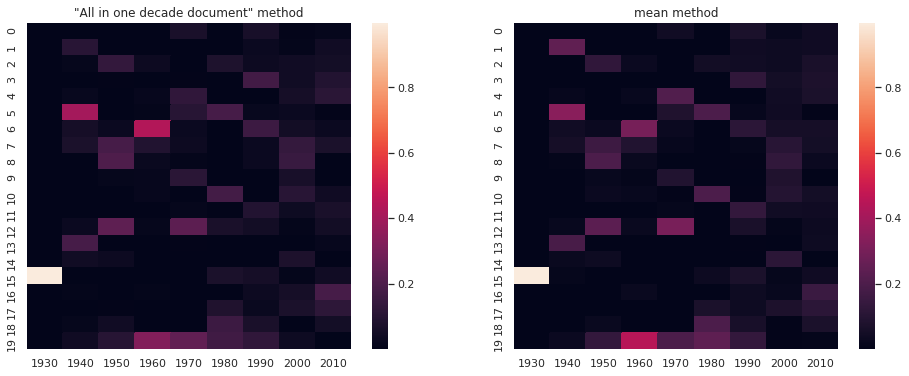

In [17]:
plt.figure(figsize=(16,6))

plt.subplot(121)
ax1 = sns.heatmap(decade_tdf.values.T, xticklabels=decade_tdf.index.values)
ax1.set_title('\"All in one decade document\" method')

plt.subplot(122)
ax2 = sns.heatmap(mean_df.values.T, xticklabels=mean_df.index.values)
ax2.set_title('mean method')

plt.show()